In [181]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

First, define a gravitational potential.

In [182]:
pot = gp.MilkyWayPotential()

Select a star.

In [183]:
dict1 = {
    'ra': 136.93746493225, #degree
    'e_ra': 0.0001,#0.4290, #degree
    'dec': 2.75190851109, #degree
    'e_dec': 0.0001,#0.3030, #degree
    'dist': 102.24, #kpc
    'e_dist': 14.60, #kpc
    'pmra': -0.60, #mas/yr
    'e_pmra': 0.60, #mas/yr
    'pmdec': -0.47, #mas/yr
    'e_pmdec': 0.39, #mas/yr
    'rv': 831.10, #km/s
    'e_rv': 5.70, #km/s
    }

hvs1 = coord.SkyCoord(
    ra=dict1['ra'] * u.degree,
    dec=dict1['dec'] * u.degree,
    distance=dict1['dist'] * u.kpc,
    pm_ra_cosdec=dict1['pmra'] * (u.mas / u.yr),
    pm_dec=dict1['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict1['rv'] * (u.km / u.s),
    frame="icrs"
)

hvs1_GC = hvs1.transform_to(coord.Galactocentric)

Set initial conditions and specify time-stepping

In [184]:
hvs1_ics = gd.PhaseSpacePosition(pos=hvs1_GC.cartesian.xyz, vel=hvs1_GC.velocity.d_xyz)
hvs1_orbit1 = pot.integrate_orbit(hvs1_ics, dt=0.1*u.Myr, n_steps=10000) # 1 Gyr
hvs1_orbit2 = pot.integrate_orbit(hvs1_ics, dt=0.1*u.Myr, n_steps=5000) # 500 Myr
hvs1_orbit3 = pot.integrate_orbit(hvs1_ics, dt=0.1*u.Myr, n_steps=1000) # 100 Myr

        Use name instead. [gala.dynamics.core]


Sample 100 clones from the uncertainties.

In [185]:
n_samples = 100
ra_samples = np.random.normal(dict1['ra'], dict1['e_ra'], n_samples)
dec_samples = np.random.normal(dict1['dec'], dict1['e_dec'], n_samples)
dist_samples = np.random.normal(dict1['dist'], dict1['e_dist'], n_samples)
pmra_samples = np.random.normal(dict1['pmra'], dict1['e_pmra'], n_samples)
pmdec_samples = np.random.normal(dict1['pmdec'], dict1['e_pmdec'], n_samples)
rv_samples = np.random.normal(dict1['rv'], dict1['e_rv'], n_samples)

ics_list = []
for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
    sc = coord.SkyCoord(ra=ra * u.degree,
                  dec=dec * u.degree,
                  distance=dist * u.kpc,
                  pm_ra_cosdec=pmra * (u.mas / u.yr),
                  pm_dec=pmdec * (u.mas / u.yr),
                  radial_velocity=rv * (u.km / u.s),
                  frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    ics_list.append(ics)

Integrate all of the orbits

In [186]:
orbits1 = []
orbits2 = []
orbits3 = []
orbits1.append(hvs1_orbit1)
orbits2.append(hvs1_orbit2)
orbits3.append(hvs1_orbit3)
for ics in ics_list:
    orbit1 = pot.integrate_orbit(ics, dt=0.1*u.Myr, n_steps=10000)
    orbit2 = pot.integrate_orbit(ics, dt=0.1*u.Myr, n_steps=5000)
    orbit3 = pot.integrate_orbit(ics, dt=0.1*u.Myr, n_steps=1000)
    orbits1.append(orbit1)
    orbits2.append(orbit2)
    orbits3.append(orbit3)

Plot the final positions of the star after 1 Gyr

Covariance matrix of red points:
[[ 51526.2524181  -17141.77818422  35169.41551654]
 [-17141.77818422  19971.34941958   3810.71236665]
 [ 35169.41551654   3810.71236665  42204.29416608]]
Mean of red points: [-590.3365224  -529.01360772  162.42681371]


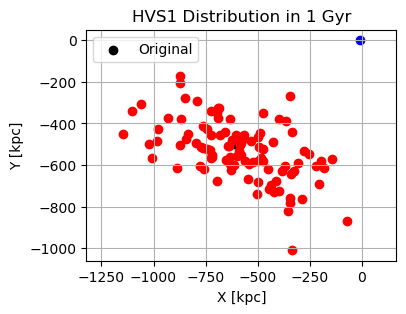

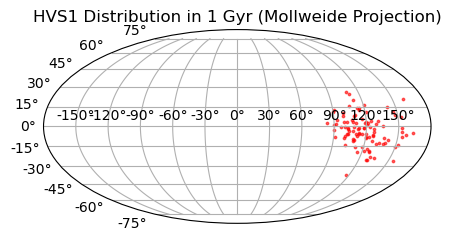

In [187]:
plt.figure(figsize=(4, 3))

red_points = []

for i, orbit in enumerate(orbits1):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
print("Covariance matrix of red points:")
print(cov)

mean_pos = np.mean(red_points, axis=0)
print("Mean of red points:", mean_pos)

# Regular Plot

plt.xlabel('X [kpc]')
plt.scatter(-8,0, c='blue')
plt.ylabel('Y [kpc]')
plt.title('HVS1 Distribution in 1 Gyr')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Mollweide projection

x, y, z = red_points[:,0], red_points[:,1], red_points[:,2]
sky_coords = coord.SkyCoord(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, frame='galactocentric').icrs
ra = sky_coords.ra.wrap_at(180*u.deg).radian
dec = sky_coords.dec.radian

plt.figure(figsize=(5, 3))
ax = plt.subplot(111, projection='mollweide')
ax.scatter(ra, dec, s=3, color='red', alpha=0.6)
ax.grid(True)
ax.set_title('HVS1 Distribution in 1 Gyr (Mollweide Projection)')
plt.show()

Plot the final positions of the star after 500 Myr

Covariance matrix of red points:
[[13003.15813978 -4294.18280732  8894.68046247]
 [-4294.18280732  5239.42494745   876.61231573]
 [ 8894.68046247   876.61231573 10713.48129494]]
Mean of red points: [-331.76728796 -299.4450979   109.20898818]


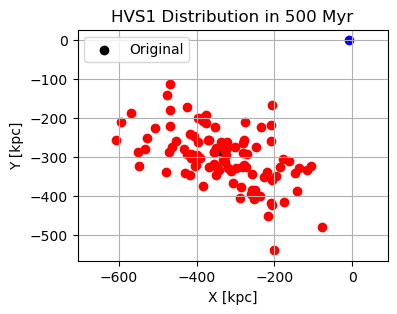

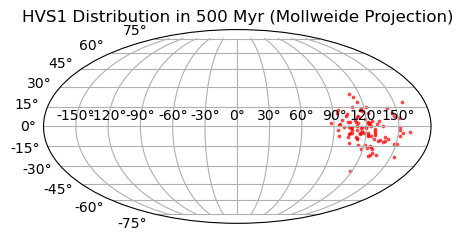

In [188]:
plt.figure(figsize=(4, 3))

red_points = []

for i, orbit in enumerate(orbits2):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
print("Covariance matrix of red points:")
print(cov)

mean_pos = np.mean(red_points, axis=0)
print("Mean of red points:", mean_pos)

# Regular Plot

plt.xlabel('X [kpc]')
plt.scatter(-8,0, c='blue')
plt.ylabel('Y [kpc]')
plt.title('HVS1 Distribution in 500 Myr')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Mollweide projection

x, y, z = red_points[:,0], red_points[:,1], red_points[:,2]
sky_coords = coord.SkyCoord(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, frame='galactocentric').icrs
ra = sky_coords.ra.wrap_at(180*u.deg).radian
dec = sky_coords.dec.radian

plt.figure(figsize=(5, 3))
ax = plt.subplot(111, projection='mollweide')
ax.scatter(ra, dec, s=3, color='red', alpha=0.6)
ax.grid(True)
ax.set_title('HVS1 Distribution in 500 Myr (Mollweide Projection)')
plt.show()

Plot the final positions of the star after 100 Myr

Covariance matrix of red points:
[[ 577.37106899 -100.72601462  324.43579903]
 [-100.72601462  321.22491258  -26.55994567]
 [ 324.43579903  -26.55994567  466.68481332]]
Mean of red points: [-121.26254531 -112.3473433    65.11050508]


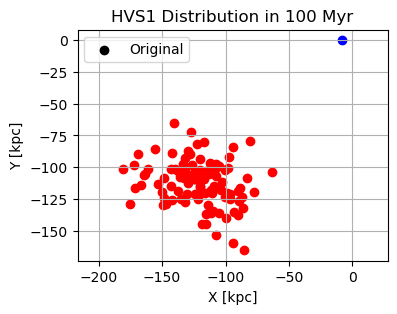

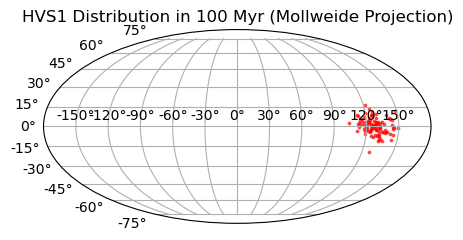

In [189]:
plt.figure(figsize=(4, 3))

red_points = []

for i, orbit in enumerate(orbits3):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
print("Covariance matrix of red points:")
print(cov)

mean_pos = np.mean(red_points, axis=0)
print("Mean of red points:", mean_pos)

# Regular Plot

plt.xlabel('X [kpc]')
plt.scatter(-8,0, c='blue')
plt.ylabel('Y [kpc]')
plt.title('HVS1 Distribution in 100 Myr')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Mollweide projection

x, y, z = red_points[:,0], red_points[:,1], red_points[:,2]
sky_coords = coord.SkyCoord(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, frame='galactocentric').icrs
ra = sky_coords.ra.wrap_at(180*u.deg).radian
dec = sky_coords.dec.radian

plt.figure(figsize=(5, 3))
ax = plt.subplot(111, projection='mollweide')
ax.scatter(ra, dec, s=3, color='red', alpha=0.6)
ax.grid(True)
ax.set_title('HVS1 Distribution in 100 Myr (Mollweide Projection)')
plt.show()

Plot the orbits

In [190]:
# plt.figure(figsize=(8, 6))

# n_steps = orbits[0].ntimes
# times = np.linspace(0, 1, n_steps)

# cmap_sampled = plt.colormaps['Blues']
# cmap_original = plt.colormaps['Greys']

# for i, orbit in enumerate(orbits):
#     pos = orbit.pos.xyz.to(u.kpc).value
#     if i == 0:
#         colors = cmap_original(1 - times)
#         plt.scatter(pos[0], pos[1], c=colors, s=1, label='Original', alpha=0.5)
#     else:
#         colors = cmap_sampled(1 - times)
#         plt.scatter(pos[0], pos[1], c=colors, s=1, alpha=0.7)

# plt.xlabel('X [kpc]')
# plt.scatter(-8,0, c='red')
# plt.ylabel('Y [kpc]')
# plt.title('HVS1')
# plt.legend()
# plt.axis('equal')
# plt.grid(True)
# plt.show()
